# Parser results -- Maltparser, default settings (1.2 updated)

This notebook will perform the same experiments as [the previous one](/notebooks/4.%20Analysis%20of%20parser%20results%20%28Mate%20tools%29.ipynb) for Mate tools, only instead using Maltparser run with default settings. We are also testing the entire UD 1.2 collection, instead of just looking at 1.0 as for Mate.

## Preprocessing

The conllu files had to be preprocessed to support the conllx format. This was done using the `tools/conllu2conllx.py` script. Thereafter the models were trained and tested with `tools/train_maltparser_default.py` and `tools/test_maltparser_default.py`.

#### Functional and content dependents
As specified in [A manual classification of dependency relations](/notebooks/3.%20A%20manual%20classification%20of%20dependency%20relations.ipynb)

- Functional dependents
- Content dependendents

#### Dependent classes as specified in the [UD documentation](http://universaldependencies.github.io/docs/u/dep/index.html)

- Classes expected to perform better than overall LAS for __synthetic__ languages:
  - __Core dependents of clausal predicates__: nsubj, csubj, nsubjpass, csubjpass, dobj, ccomp, xcomp, iobj
  - __Non-core dependents of clausal predicates__: nmod, advcl, advmod, neg
  - __Noun dependents, excluding _det_ and _neg___: nummod, acl, amod, appos, nmod
  - __Coordination, excluding _cc_ and _punct___: conj
  - 
- Classes expected to perform better than overall LAS for __isolated__ languages:
  - __Special clausal dependents__: vocative, aux, mark, discourse, auxpass, punct, expl, cop
  - __Case-marking, prepositions, possessive__: case


## Things to keep in mind when looking at the results

- Irish and Hungarian has fairly little data, and can't probably be trusted. 
- Czech has A LOT of data.

In [57]:
# Matplotlib
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
mpl.style.use('ggplot')
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pgf', FigureCanvasPgf)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys, os
sys.path.append("../tools/")
from collections import defaultdict

# Data management libraries
import pandas as pd
#import seaborn as sns

# Treebank utils, found in "../tools"
import udeval, lang_utils, dependency_classes

is_labeled = True
is_fine_grained_deprels = False
file_format = "conllx"
test_type = "test"

system_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/maltdefault_coarse_output_test_1-2/"
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-2/universal-dependencies-1.2/"
file_prefix = "maltdefault"

system_files = lang_utils.get_system_output_paths(system_output_base, type_=test_type, format_=file_format)
gold_files = lang_utils.get_ud_paths(gold_output_base, type_=test_type, format_=file_format, coarse=not is_fine_grained_deprels)

def labeled_attachment_scores():
    las = {}
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang]
        score = udeval.attachment_score(s_out, g_out, labeled=is_labeled, fine_grained_deprels=is_fine_grained_deprels)
        las[lang] = score
    return pd.Series(las)

def weighted_attachment_scores():
    las = {}
    iwe = (1 - pd.Series.from_csv('../data/degree_of_functionality.inverse_word_entropy.csv')).to_dict()
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang]
        score = udeval.weighted_las(s_out, g_out, iwe)
        las[lang] = score
    return pd.Series(las)

def precision_recall_filter_labels(labels):
    prec_recs = {"precision": [], "recall": []}
    index = []
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang]
        precision, recall = udeval.labels_precision_recall(s_out, 
                                                           g_out, 
                                                           labels=labels,
                                                           fine_grained_deprels=is_fine_grained_deprels)
        index.append(lang)
        prec_recs["precision"].append(precision)
        prec_recs["recall"].append(recall)

    return pd.DataFrame(prec_recs, index=index).sort_values("precision")

In [58]:
was = weighted_attachment_scores()
was.sort_values()

Basque                 0.617922
Finnish                0.643300
Gothic                 0.644409
Dutch                  0.660127
Old_Church_Slavonic    0.684044
Croatian               0.709289
Greek                  0.718925
Danish                 0.739050
Arabic                 0.741852
Spanish                0.751980
Hebrew                 0.753486
Portuguese             0.772574
Swedish                0.783530
Persian                0.787218
Czech                  0.799483
Slovenian              0.800210
Bulgarian              0.801224
English                0.814451
Polish                 0.819191
Italian                0.821376
Norwegian              0.827010
Hindi                  0.841281
dtype: float64

In [3]:
las = labeled_attachment_scores()
las.to_csv('../data/' + file_prefix + '.las.csv')
las

Arabic                 0.750106
Basque                 0.644170
Bulgarian              0.822423
Croatian               0.703273
Czech                  0.797729
Danish                 0.754929
Dutch                  0.664996
English                0.822840
Finnish                0.662801
Gothic                 0.669833
Greek                  0.732534
Hebrew                 0.775340
Hindi                  0.873553
Italian                0.844503
Norwegian              0.844676
Old_Church_Slavonic    0.707816
Persian                0.796967
Polish                 0.832846
Portuguese             0.790012
Slovenian              0.810425
Spanish                0.780209
Swedish                0.793493
dtype: float64

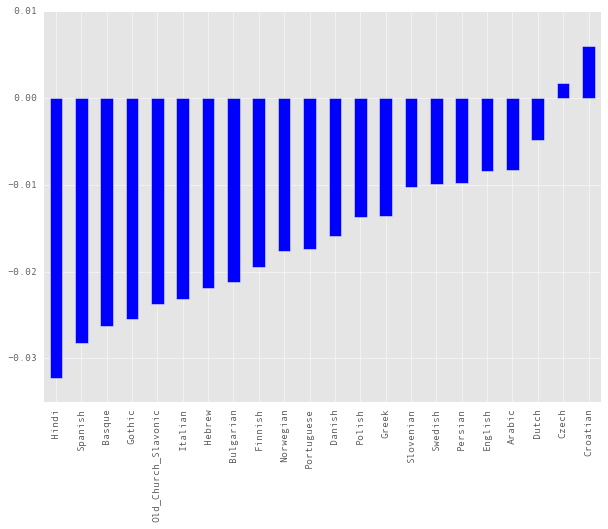

In [77]:
was_diffs = (was - las).sort_values()
was_diffs.plot(kind='bar')

,WLAS,LAS
Basque,0.617922,0.644170
Finnish,0.643300,0.662801
Gothic,0.644409,0.669833
Dutch,0.660127,0.664996
Old_Church_Slavonic,0.684044,0.707816
Croatian,0.709289,0.703273
Greek,0.718925,0.732534
Danish,0.739050,0.754929
Arabic,0.741852,0.750106
Spanish,0.751980,0.780209


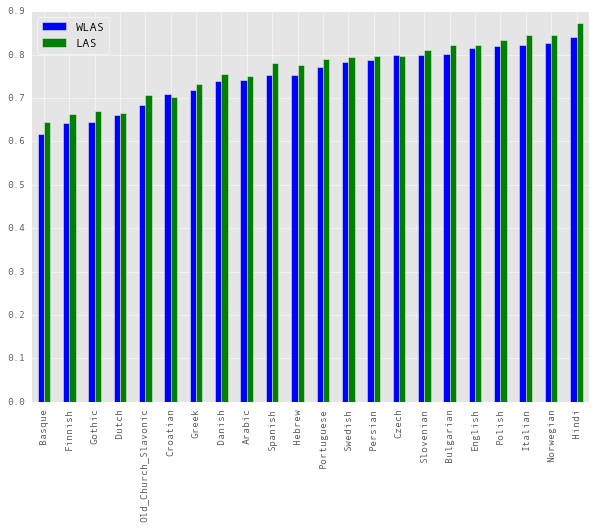

In [81]:
res = pd.concat([was, las], axis=1).rename(columns={0:'WLAS', 1:'LAS'}).sort_values('WLAS')
res.plot(kind='bar')
res

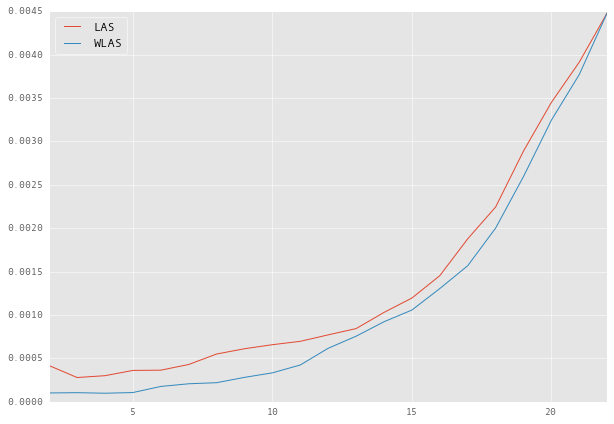

In [82]:
vals = ["WLAS", "LAS"]
vars = {"LAS": [], "WLAS": []}
for val in vals:
    for i in range(2, len(result_comparison)+1):
        vars[val].append(res.sort_values(val, ascending=False)[val].ix[:i].var())

vars = pd.DataFrame(vars)
vars.index = range(2,len(result_comparison)+1)
vars.plot(legend=True)

In [4]:
all_labels_results = precision_recall_filter_labels(dependency_classes.all_labels)
all_labels_results

,precision,recall
Basque,0.644170,0.644170
Finnish,0.662801,0.662801
Dutch,0.664996,0.664996
Gothic,0.669833,0.669833
Croatian,0.703273,0.703273
Old_Church_Slavonic,0.707816,0.707816
Greek,0.732534,0.732534
Arabic,0.750106,0.750106
Danish,0.754929,0.754929
Hebrew,0.775340,0.775340


# Performance for dependency classes

We calculate the precision and recall only using the labels classified as content relations. We then subtract the LAS to present how large of an increase (or reduction) in results the label class gets.

### Content and function relations

#### Absolute performance

In [5]:
content_dependents_result = precision_recall_filter_labels(dependency_classes.content_dependents)
function_dependents_result = precision_recall_filter_labels(dependency_classes.function_dependents)
nonsemantic_dependents_result = precision_recall_filter_labels(dependency_classes.nonsemantic_dependents)
results_dict = {"Content": content_dependents_result, 
                "Function": function_dependents_result,
                "Nonsemantic": nonsemantic_dependents_result}

content_function_results = pd.concat(results_dict.values(), keys=results_dict.keys(), axis=1)

In [6]:
content_function_results.to_csv('../data/' + file_prefix + '.content_function_deprels.las.csv')
content_function_results

Nonsemantic            Function             Content  \
                      precision    recall precision    recall precision   
Arabic                 0.779388  0.749226  0.825058  0.810317  0.716505   
Basque                 0.684042  0.593332  0.857873  0.823987  0.574014   
Bulgarian              0.818064  0.812098  0.921854  0.916795  0.772891   
Croatian               0.637931  0.594855  0.820272  0.814315  0.674652   
Czech                  0.746595  0.695466  0.890820  0.875164  0.778110   
Danish                 0.728411  0.662116  0.898154  0.879813  0.690546   
Dutch                  0.648472  0.453435  0.844731  0.791076  0.571343   
English                0.775000  0.751632  0.921443  0.919656  0.784849   
Finnish                0.711940  0.692308  0.761481  0.762046  0.631938   
Gothic                 0.732759  0.745614  0.804772  0.812409  0.616835   
Greek                  0.619962  0.544688  0.894201  0.867292  0.651053   
Hebrew                 0.690780  0.612194  0.922227  0.923529  0.697012   
Hindi                  0.956348  0.895436  0.963245  0.962782  0.807023   
Italian                0.741564  0.728964  0.954366  0.954995  0.771964   
Norwegian              0.843332  0.807954  0.916245  0.931639  0.803790   
Old_Church_Slavonic    0.834254  0.743842  0.852444  0.836824  0.658627   
Persian                0.756857  0.728245  0.900920  0.880674  0.758404   
Polish                 0.861301  0.859829  0.907010  0.903134  0.803204   
Portuguese             0.665428  0.621528  0.948301  0.941988  0.712555   
Slovenian              0.789474  0.748011  0.906062  0.899080  0.768859   
Spanish                0.649880  0.634660  0.918885  0.915484  0.692980   
Swedish                0.715663  0.706134  0.886657  0.874674  0.756714   

                               
                       recall  
Arabic               0.725658  
Basque               0.600554  
Bulgarian            0.776560  
Croatian             0.687672  
Czech                0.796339  
Danish               0.714676  
Dutch                0.631405  
English              0.790791  
Finnish              0.635584  
Gothic               0.614317  
Greek                0.679462  
Hebrew               0.716423  
Hindi                0.814800  
Italian              0.774656  
Norwegian            0.803504  
Old_Church_Slavonic  0.666220  
Persian              0.769813  
Polish               0.804598  
Portuguese           0.730000  
Slovenian            0.781116  
Spanish              0.698730  
Swedish              0.764176

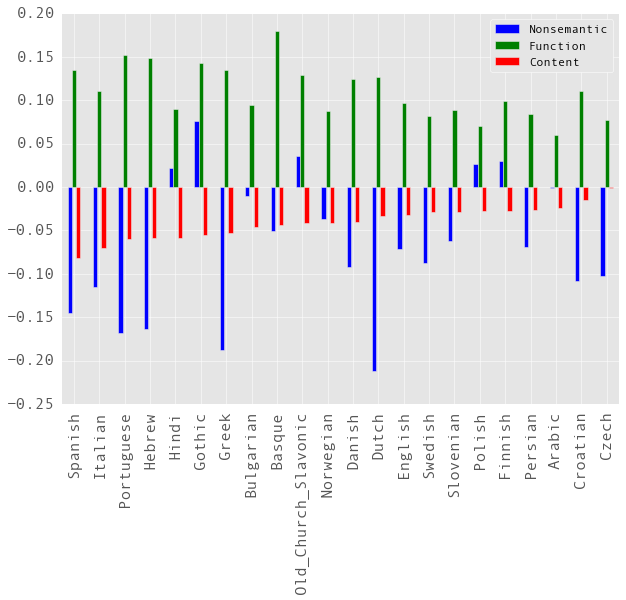

In [7]:
content_function_precisions = content_function_results.subtract(all_labels_results, level=1).xs('recall', level=1, axis=1)
content_recall = content_function_precisions.sort_values('Content')['Content']
content_function_precisions.sort_values('Content').plot(kind='bar', fontsize=16)

In [8]:
pd.concat([pd.DataFrame.from_csv('../data/standard_ttr.1.2.csv')['mean'], content_function_results], axis=1).corr()

,mean,"(Nonsemantic, precision)","(Nonsemantic, recall)","(Function, precision)","(Function, recall)","(Content, precision)","(Content, recall)"
mean,1.000000,0.274534,0.242772,0.372261,0.382748,0.319101,0.324428
"(Nonsemantic, precision)",0.274534,1.000000,0.912208,0.308098,0.388374,0.650482,0.610981
"(Nonsemantic, recall)",0.242772,0.912208,1.000000,0.283384,0.429802,0.744335,0.656652
"(Function, precision)",0.372261,0.308098,0.283384,1.000000,0.966026,0.662361,0.709218
"(Function, recall)",0.382748,0.388374,0.429802,0.966026,1.000000,0.748413,0.758649
"(Content, precision)",0.319101,0.650482,0.744335,0.662361,0.748413,1.000000,0.985554
"(Content, recall)",0.324428,0.610981,0.656652,0.709218,0.758649,0.985554,1.000000


WLAS                 0.000334
Content recall       0.000285
Content precision    0.000345
LAS                  0.000658
dtype: float64

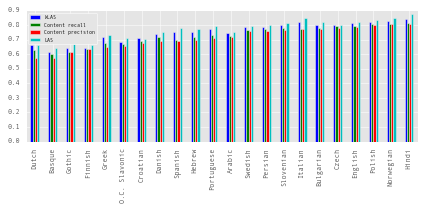

In [89]:
result_comparison = pd.concat([res['WLAS'],
                               content_function_results['Content']['recall'], 
                               content_function_results['Content']['precision'], las], axis=1
                             ).rename(columns={'recall': 'Content recall', 
                                               'precision': "Content precision", 
                                               0: 'LAS'}).sort_values('Content precision')
renamed = result_comparison.rename(index={'Old_Church_Slavonic': 'O.C. Slavonic'})
ax = renamed.plot(kind='bar', figsize=(6,3), fontsize=7, legend=False)
ax.legend(loc=2, fontsize=5)
plt.tight_layout()
plt.savefig('../paper/figures/content_las_comparison.pgf')
result_comparison.ix[-10:].var()

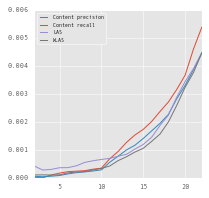

In [90]:
vals = ["Content precision", "Content recall", "WLAS", "LAS"]
vars = {"Content precision": [], "Content recall": [], "LAS": [], "WLAS": []}
for val in vals:
    for i in range(2, len(result_comparison)+1):
        vars[val].append(result_comparison.sort_values(val, ascending=False)[val].ix[:i].var())

vars = pd.DataFrame(vars)
vars.index = range(2,len(result_comparison)+1)
vars.plot(figsize=(3,3), legend=False, fontsize=7)
plt.legend(fontsize=5, loc=2)
plt.savefig('../paper/figures/cumul_vars.pgf')

# What does this actually tell us?

Nothing, really, so far. Finnish might perform well on the few function relations it actually has. We need to look into function relations given how often they occur in the output. This is to be done in a later notebook.

In [38]:
core_dependent_result = precision_recall_filter_labels(dependency_classes.core_dependents)
noncore_dependent_result = precision_recall_filter_labels(dependency_classes.noncore_dependents)
coordination_dependent_result = precision_recall_filter_labels(dependency_classes.coordination_dependents)
special_clausal_dependent_result = precision_recall_filter_labels(dependency_classes.special_clausal_dependents)
noun_dependent_result = precision_recall_filter_labels(dependency_classes.noun_dependents)
other_dependent_result = precision_recall_filter_labels(dependency_classes.other_dependents)
compound_and_unanalyzed_dependent_result = precision_recall_filter_labels(dependency_classes.compound_and_unanalyzed_dependents)
case_marking_dependent_result = precision_recall_filter_labels(dependency_classes.case_marking_dependents)
loose_joining_dependent_result = precision_recall_filter_labels(dependency_classes.loose_joining_dependents)

ud_result_dict = {'core': core_dependent_result,
                  'noncore': noncore_dependent_result,
                  'coordination': coordination_dependent_result,
                  'special_clausal': special_clausal_dependent_result,
                  'noun': noun_dependent_result,
                  'other': other_dependent_result,
                  'compound_and_unanalyzed': compound_and_unanalyzed_dependent_result,
                  'case_marking': case_marking_dependent_result,
                  'loose_joining': loose_joining_dependent_result}

ud_class_result = pd.concat(ud_result_dict.values(), keys=ud_result_dict.keys(), axis=1)
ud_class_result.to_csv('../data/' + file_prefix + '.ud_classes.las.csv')
ud_class_result

coordination                noun               other  \
                       precision    recall precision    recall precision   
Arabic                  0.640172  0.623648  0.757206  0.777393  0.715128   
Basque                  0.675859  0.609540  0.665756  0.633084  0.472667   
Bulgarian               0.736889  0.759490  0.832918  0.819029  0.801809   
Croatian                0.643991  0.610097  0.743316  0.772222  0.531447   
Czech                   0.712200  0.689033  0.845048  0.845095  0.609783   
Danish                  0.696649  0.665543  0.784530  0.727739  0.524621   
Dutch                   0.579390  0.497292  0.797714  0.778583  0.337810   
English                 0.747973  0.728495  0.837929  0.840389  0.803286   
Finnish                 0.689919  0.673846  0.661210  0.637612  0.695302   
Gothic                  0.608516  0.576073  0.685558  0.648228  0.621257   
Greek                   0.544565  0.498012  0.832590  0.828894  0.446953   
Hebrew                  0.660795  0.661392  0.795736  0.828157  0.770035   
Hindi                   0.907341  0.863422  0.828156  0.849871  0.786829   
Italian                 0.695487  0.684690  0.889906  0.884376  0.797373   
Norwegian               0.807685  0.786862  0.831139  0.825759  0.791031   
Old_Church_Slavonic     0.649856  0.627260  0.746309  0.641292  0.674253   
Persian                 0.765253  0.737787  0.807018  0.848590  0.686922   
Polish                  0.815333  0.819156  0.813966  0.800549  0.897333   
Portuguese              0.665741  0.621435  0.860244  0.859855  0.523810   
Slovenian               0.739814  0.709633  0.850900  0.826673  0.556658   
Spanish                 0.634328  0.612833  0.822409  0.835630  0.650289   
Swedish                 0.702563  0.701224  0.815859  0.811684  0.781083   

                                noncore           special_clausal            \
                       recall precision    recall       precision    recall   
Arabic               0.847497  0.683173  0.709896        0.792517  0.756047   
Basque               0.768980  0.609291  0.582593        0.770183  0.694343   
Bulgarian            0.873656  0.745461  0.743987        0.846048  0.839550   
Croatian             0.845000  0.705018  0.733758        0.701477  0.668342   
Czech                0.814224  0.775514  0.769722        0.786312  0.750158   
Danish               0.847095  0.684838  0.662819        0.802548  0.753488   
Dutch                0.694268  0.684622  0.641694        0.708235  0.551282   
English              0.894129  0.779724  0.776658        0.838958  0.822810   
Finnish              0.799383  0.616288  0.601682        0.713673  0.692508   
Gothic               0.855670  0.632264  0.597541        0.815068  0.762821   
Greek                0.801619  0.680460  0.707006        0.730594  0.666667   
Hebrew               0.600543  0.699819  0.734345        0.752694  0.744670   
Hindi                0.941686  0.773904  0.815628        0.950425  0.918734   
Italian              0.869121  0.779227  0.780317        0.801128  0.797042   
Norwegian            0.909747  0.760435  0.763380        0.868840  0.860877   
Old_Church_Slavonic  0.825784  0.662239  0.631674        0.871739  0.842437   
Persian              0.813772  0.754893  0.802915        0.785865  0.746983   
Polish               0.925722  0.765448  0.756386        0.866258  0.857316   
Portuguese           0.823129  0.702778  0.678891        0.699902  0.658694   
Slovenian            0.851899  0.815037  0.765147        0.845758  0.816152   
Spanish              0.789474  0.697578  0.711864        0.740506  0.731758   
Swedish              0.840033  0.724743  0.727065        0.788462  0.783240   

                    case_marking           compound_and_unanalyzed            \
                       precision    recall               precision    recall   
Arabic                  0.952404  0.954722                     NaN       NaN   
Basque                  0.977887  0.973105                

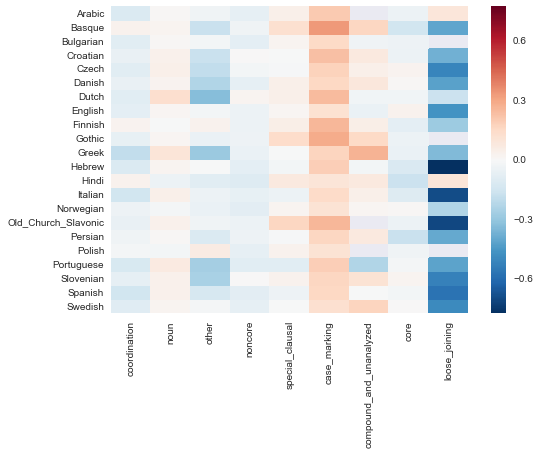

In [56]:
sns.heatmap(ud_class_result.xs('precision', axis=1, level=1).subtract(all_labels_results['precision'], axis=0))

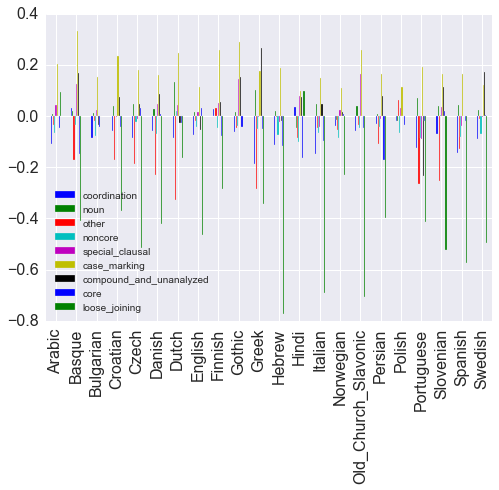

In [39]:
relative_ud_class_result = ud_class_result.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
relative_ud_class_result.plot(kind='bar', fontsize=16)

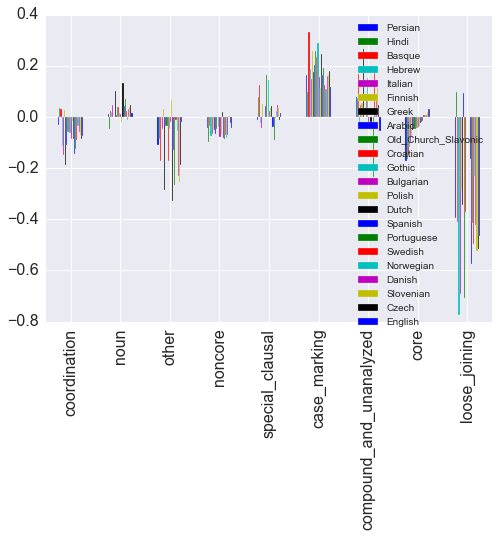

In [40]:
relative_ud_class_result.sort_values("core").transpose().plot(kind='bar', fontsize=16)

In [11]:
add_order = [('core', dependency_classes.core_dependents),
             ('noncore', dependency_classes.noncore_dependents),
             ('coordination', dependency_classes.coordination_dependents),
             ('special_clausal', dependency_classes.special_clausal_dependents),
             ('noun', dependency_classes.noun_dependents),
             ('other', dependency_classes.other_dependents),
             ('compound_and_unanalyzed', dependency_classes.compound_and_unanalyzed_dependents),
             ('case_marking', dependency_classes.case_marking_dependents),
             ('loose_joining', dependency_classes.loose_joining_dependents)]


labels = []
cumul_results = []
cumul_name = ""
for class_name, label_class in add_order:
    labels += label_class
    labels_result = precision_recall_filter_labels(labels)
    cumul_name = "+" + class_name
    cumul_results.append((cumul_name, labels_result))

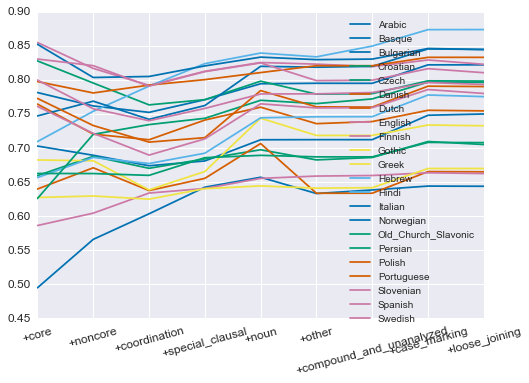

In [12]:
cmap1 = mpl.colors.ListedColormap(sns.color_palette("colorblind", 10))
pd.DataFrame([x[1]['precision'] for x in cumul_results], index=[x[0] for x in cumul_results]).plot(rot=15, fontsize=12, cmap=cmap1)

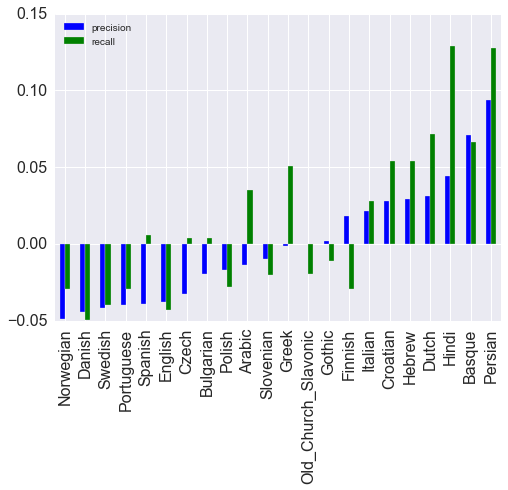

In [13]:
(cumul_results[1][1] - cumul_results[0][1]).sort_values("precision").plot(kind='bar', fontsize=16)

In [14]:
precision_recall_filter_labels(dependency_classes.all_labels)

,precision,recall
Basque,0.644170,0.644170
Finnish,0.662801,0.662801
Dutch,0.664996,0.664996
Gothic,0.669833,0.669833
Croatian,0.703273,0.703273
Old_Church_Slavonic,0.707816,0.707816
Greek,0.732534,0.732534
Arabic,0.750106,0.750106
Danish,0.754929,0.754929
Hebrew,0.775340,0.775340
